In [174]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
import keras
from scipy.io import loadmat
from callbacks import *
from load_data import *
from keras.regularizers import l2
from Models.Base import BaseNN
from Models.PCA import PCANN
from sklearn.decomposition import PCA

In [190]:
model = Sequential()
model.add(Dense(10, input_dim=400, activation='sigmoid'))# , kernel_regularizer = l2(0.07)))

X_train, X_test, y_train, y_test = load_small_mnist(0.4)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

ca_callback = CACallback(X_test, oneHot(y_test), X_train, oneHot(y_train))
loss_callback = LossCallback(X_test, oneHot(y_test), X_train, oneHot(y_train))
itr_callback = IterationCallback(5)

model.fit(X_train, oneHot(y_train), epochs=20, batch_size=10, verbose=0, callbacks=[ca_callback, loss_callback])

In [191]:
from aa import AA

mid_dim1 = 15
mid_dim2 = 12
mid_dim3 = 11

dims = [15, 12, 11]

models = [Sequential() for m in range(len(dims)+1)]
models[0].add(Dense(dims[0], input_dim=400, activation='sigmoid'))
models[1].add(Dense(dims[1], input_dim=dims[0], activation='sigmoid'))
models[2].add(Dense(dims[2], input_dim=dims[1], activation='sigmoid'))
models[3].add(Dense(10, input_dim=dims[2], activation='sigmoid'))

for m in models:
    m.compile(loss='categorical_crossentropy', optimizer='adam')

X_train, X_test, y_train, y_test = load_small_mnist(0.2)

a1 = AA(X_train, dims[0])
a1.factorize(15)

a2 = AA(X_train, dims[1])
a2.factorize(15)

a3 = AA(X_train, dims[2])
a3.factorize(15)

aWs = [a1.W, a2.W, a3.W]

In [192]:
itras = 10
batch_size = 10
models[0].fit(X_train, aWs[0], epochs=itras, batch_size=batch_size, verbose=0)
models[1].fit(aWs[0], aWs[1], epochs=itras, batch_size=batch_size, verbose=0)
models[2].fit(aWs[1], aWs[2], epochs=itras, batch_size=batch_size, verbose=0)
models[3].fit(aWs[2], oneHot(y_train), epochs=itras, batch_size=batch_size, verbose=0)

weights1 = models[0].layers[0].get_weights()
weights2 = models[1].layers[0].get_weights()
weights2_5 = models[2].layers[0].get_weights()
weights2_6 = models[3].layers[0].get_weights()

model3 = Sequential()
model3.add(Dense(mid_dim1, input_dim=400, activation='sigmoid', weights = weights1))
model3.add(Dense(mid_dim2, input_dim=mid_dim1, activation='sigmoid', weights = weights2))
model3.add(Dense(mid_dim3, input_dim=mid_dim2, activation='sigmoid', weights = weights2_5))
model3.add(Dense(10, input_dim=mid_dim3, activation='sigmoid', weights = weights2_6))

model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

ca_callback = CACallback(X_test, oneHot(y_test), X_train, oneHot(y_train))
model3.fit(X_train, oneHot(y_train), epochs=100, batch_size=50, verbose=0, callbacks=[ca_callback])
svd = ca_callback.get_data()

In [193]:
class LDANN:
    def __init__(self, layers=[400, 25, 10]):
        self.layers = layers
        self.model = Sequential()

    def fit(self, X_test, y_test, X_train, y_train, epochs=200, batch_size=10):
        scaler = MinMaxScaler(feature_range=(-1, 1))
        activ = [X_train]
        for i in range(1, len(self.layers) - 1):
            print(LinearDiscriminantAnalysis(n_components=21)
                                              .fit(X_train, y_train).transform(X_train).shape)
            activ.append(scaler.fit_transform(
                                              LinearDiscriminantAnalysis(n_components=self.layers[i])
                                              .fit(X_train, y_train).transform(X_train)))
        activ.append(oneHot(y_train))

        for sdfg in activ:
            print(sdfg.shape)
        
        NN_layers = []
        for i in range(len(self.layers) - 1):
            model = Sequential()
            model.add(Dense(self.layers[i + 1], input_dim=self.layers[i], activation='sigmoid'))
            model.compile(loss='mean_squared_error', optimizer='adam')
            print(activ[i].shape, activ[i + 1].shape)
            model.fit(activ[i], activ[i + 1], epochs=30, batch_size=10, verbose=0)
            NN_layers.append(model)

        for i in range(len(self.layers) - 1):
            self.model.add(Dense(self.layers[i + 1],
                                 input_dim=self.layers[i],
                                 activation='sigmoid',
                                 weights=NN_layers[i].layers[0].get_weights()))

        self.model.compile(loss='categorical_crossentropy',
                           optimizer='adam',
                           metrics=['accuracy'])

        ca_callback = CACallback(X_test, oneHot(y_test), X_train, oneHot(y_train))
        self.model.fit(X_train, oneHot(y_train), epochs=epochs, batch_size=batch_size, verbose=0,
                       callbacks=[ca_callback])
        return ca_callback.get_data()

In [194]:
base_model = PCANN([400, 15, 12, 11, 10])
pca = base_model.fit(X_test, y_test, X_train, y_train, 100, 50)
base_model = BaseNN([400, 15, 12, 11, 10])
random = base_model.fit(X_test, y_test, X_train, y_train, 100, 50)

In [171]:
#base_model = LDANN([400, 15, 12, 11, 10])
#lda = base_model.fit(X_test, y_test, X_train, y_train, 100, 5)

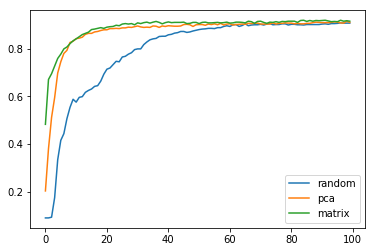

In [195]:
#plt.clear()
plt.plot(random[1], label = "random")
plt.plot(pca[1], label = "pca")
plt.plot(svd[1], label = "matrix")
plt.legend(loc='lower right')
plt.show()

(1000,)
explained variance ratio (first two components): [ 0.11919369  0.07738365]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


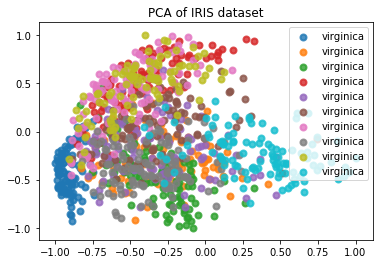

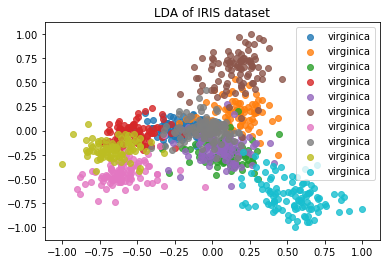

In [180]:
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import MinMaxScaler
iris = datasets.load_iris()

X = X_test
y = y_test

slc = MinMaxScaler(feature_range=(-1, 1))
pca = PCA(n_components=2)
X_r = slc.fit_transform(pca.fit(X).transform(X))
print(y.shape)
lda = LinearDiscriminantAnalysis(n_components=2)
X_r2 = slc.fit_transform(lda.fit(X, y).transform(X))

# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

plt.figure()
lw = 2

for i in [0, 1, 2, 3,4,5,6,7,8,9]:
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of IRIS dataset')

plt.figure()
for i in [0, 1, 2,3,4,5,6,7,8,9]:
    plt.scatter(X_r2[y == i, 0], X_r2[y == i, 1], alpha=.8,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('LDA of IRIS dataset')

plt.show()